In [1]:
# import torch
# import torch.nn as nn
# import torch.optim as optim
# from torch.utils.data import DataLoader, Subset, TensorDataset
# from sklearn.datasets import make_classification
# from sklearn.model_selection import KFold, train_test_split
# from sklearn.preprocessing import StandardScaler
# import numpy as np
# import pandas as pd
# from sklearn.metrics import recall_score
# from imblearn.over_sampling import SMOTE

# data = pd.read_csv('pseudodata_præoperation.csv')

# # # #make pd to np
# X = data.to_numpy()
# y = np.random.choice([0, 1], size=len(data))

# X = StandardScaler().fit_transform(X)

# # Convert to PyTorch tensors
# X_tensor = torch.tensor(X, dtype=torch.float32)
# y_tensor = torch.tensor(y, dtype=torch.long)

# smote = SMOTE()
# X_resampled, y_resampled = smote.fit_resample(X_tensor.numpy(), y_tensor.numpy())
# X_resampled = torch.tensor(X_resampled, dtype=torch.float32)
# y_resampled = torch.tensor(y_resampled, dtype=torch.float32)

# # Create a dataset
# dataset = TensorDataset(X_tensor, y_tensor)

# # Split data into holdout set and remaining set
# indices = np.arange(len(dataset))
# np.random.seed(42)
# np.random.shuffle(indices)
# holdout_indices = indices[:500]
# remaining_indices = indices[500:]

# holdout_set = Subset(dataset, holdout_indices)
# remaining_set = Subset(dataset, remaining_indices)

# # Define the ANN model with L2 regularization
# class DeepANNModel(nn.Module):
#     def __init__(self, input_dim, hidden_dims, output_dim):
#         super(DeepANNModel, self).__init__()
#         self.input_dim = input_dim
#         self.hidden_layers = nn.ModuleList([
#             nn.Linear(input_dim if i == 0 else hidden_dims[i-1], hidden_dim)
#             for i, hidden_dim in enumerate(hidden_dims)
#         ])
#         self.output_layer = nn.Linear(hidden_dims[-1], output_dim)
#         self.relu = nn.ReLU()
#         self.sigmoid = nn.Sigmoid()

#     def forward(self, x):
#         for layer in self.hidden_layers:
#             x = self.relu(layer(x))
#         x = self.sigmoid(self.output_layer(x))
#         return x

# input_dim = 575
# hidden_dims = [128,64]
# output_dim = 2

# # Function to train and evaluate the model with L2 regularization
# def train_and_evaluate_model(train_loader, val_loader, input_dim, hidden_dim, output_dim, num_epochs=10, lr=0.01, weight_decay=1e-5):
#     model = DeepANNModel(input_dim, hidden_dim, output_dim)
#     criterion = nn.CrossEntropyLoss()
#     optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=weight_decay)
    
#     # Training loop
#     for epoch in range(num_epochs):
#         model.train()
#         for images, labels in train_loader:
#             # Forward pass
#             outputs = model(images)
#             loss = criterion(outputs, labels)
            
#             # Backward pass and optimization
#             optimizer.zero_grad()
#             loss.backward()
#             optimizer.step()
    
#     # Evaluate on validation set
#     model.eval()
#     correct = 0
#     total = 0
#     with torch.no_grad():
#         for images, labels in val_loader:
#             outputs = model(images)
#             _, predicted = torch.max(outputs.data, 1)
#             total += labels.size(0)
#             correct += (predicted == labels).sum().item()
    
#     accuracy = correct / total
#     return accuracy, model

# # Outer 10-Fold Cross-Validation
# outer_kf = KFold(n_splits=2, shuffle=True, random_state=42)
# outer_accuracies = []
# best_model_params = None
# best_outer_accuracy = 0

# for outer_train_index, outer_test_index in outer_kf.split(remaining_indices):
#     outer_train_subset = Subset(remaining_set, outer_train_index)
#     outer_test_subset = Subset(remaining_set, outer_test_index)
    
#     # Inner 10-Fold Cross-Validation
#     inner_kf = KFold(n_splits=2, shuffle=True, random_state=42)
#     inner_accuracies = []

#     for inner_train_index, inner_val_index in inner_kf.split(outer_train_index):
#         inner_train_indices = np.array(outer_train_index)[inner_train_index]
#         inner_val_indices = np.array(outer_train_index)[inner_val_index]
        
#         inner_train_subset = Subset(remaining_set, inner_train_indices)
#         inner_val_subset = Subset(remaining_set, inner_val_indices)
        
#         train_loader = DataLoader(inner_train_subset, batch_size=64, shuffle=True)
#         val_loader = DataLoader(inner_val_subset, batch_size=64, shuffle=False)
        
#         accuracy, model = train_and_evaluate_model(train_loader, val_loader, input_dim, hidden_dims, output_dim)
#         inner_accuracies.append(accuracy)
#         print(f'Inner Fold Accuracy: {accuracy * 100:.2f}%')

#     mean_inner_accuracy = np.mean(inner_accuracies)
#     print(f'Outer Fold Mean Inner Accuracy: {mean_inner_accuracy * 100:.2f}%')

#     train_loader = DataLoader(outer_train_subset, batch_size=64, shuffle=True)
#     test_loader = DataLoader(outer_test_subset, batch_size=64, shuffle=False)
    
#     outer_accuracy, outer_model = train_and_evaluate_model(train_loader, test_loader, input_dim, hidden_dims, output_dim)
#     outer_accuracies.append(outer_accuracy)
#     print(f'Outer Fold Accuracy: {outer_accuracy * 100:.2f}%')

#     if outer_accuracy > best_outer_accuracy:
#         best_outer_accuracy = outer_accuracy
#         best_model_params = outer_model.state_dict()

# print(f'Mean Outer Accuracy: {np.mean(outer_accuracies) * 100:.2f}%')
# print('Best model parameters:', best_model_params)

# # Evaluate the final model on the holdout set
# final_model = DeepANNModel(input_dim, hidden_dims, output_dim)
# final_model.load_state_dict(best_model_params)
# train_loader = DataLoader(remaining_set, batch_size=64, shuffle=True)
# holdout_loader = DataLoader(holdout_set, batch_size=64, shuffle=False)

# import torch
# from sklearn.metrics import precision_score, recall_score

# def evaluate_holdout(model, holdout_loader):
#     model.eval()
#     all_preds = []
#     all_labels = []
#     with torch.no_grad():
#         for images, labels in holdout_loader:
#             outputs = model(images)
#             _, predicted = torch.max(outputs.data, 1)
#             all_preds.extend(predicted.cpu().numpy())
#             all_labels.extend(labels.cpu().numpy())
    
#     precision = precision_score(all_labels, all_preds, average='macro')
#     recall = recall_score(all_labels, all_preds, average='macro')
#     return precision, recall

# # Example usage
# holdout_precision, holdout_recall = evaluate_holdout(final_model, holdout_loader)
# print(f'Holdout Set Precision: {holdout_precision * 100:.2f}%')
# print(f'Holdout Set Recall: {holdout_recall * 100:.2f}%')



Inner Fold Accuracy: 49.03%
Inner Fold Accuracy: 53.06%
Outer Fold Mean Inner Accuracy: 51.04%
Outer Fold Accuracy: 48.77%
Inner Fold Accuracy: 44.64%
Inner Fold Accuracy: 48.73%
Outer Fold Mean Inner Accuracy: 46.69%
Outer Fold Accuracy: 50.89%
Mean Outer Accuracy: 49.83%
Best model parameters: OrderedDict({'hidden_layers.0.weight': tensor([[-0.0138,  0.0305,  0.0051,  ...,  0.0293,  0.0022, -0.0150],
        [ 0.0095, -0.0010, -0.0061,  ...,  0.0014,  0.0376,  0.0207],
        [ 0.0045, -0.0320,  0.0089,  ...,  0.0050,  0.0387,  0.0084],
        ...,
        [ 0.0161, -0.0161, -0.0076,  ..., -0.0323, -0.0165,  0.0308],
        [ 0.0155,  0.0120, -0.0122,  ...,  0.0195,  0.0349, -0.0402],
        [-0.0280,  0.0044, -0.0012,  ...,  0.0116, -0.0196, -0.0101]]), 'hidden_layers.0.bias': tensor([-0.0310, -0.0342, -0.0041,  0.0081,  0.0353,  0.0243, -0.0147, -0.0115,
        -0.0412,  0.0405,  0.0401, -0.0223, -0.0274, -0.0072,  0.0231,  0.0215,
         0.0126, -0.0195, -0.0388, -0.0075,  

In [ ]:
# import torch
# import numpy as np
# import matplotlib.pyplot as plt
# from sklearn.metrics import roc_curve, roc_auc_score

# def evaluate_roc_auc(model, holdout_loader):
#     model.eval()
#     all_probs = []
#     all_labels = []
#     with torch.no_grad():
#         for images, labels in holdout_loader:
#             outputs = model(images)
#             probs = torch.softmax(outputs, dim=1)[:, 1]  # Assuming binary classification
#             all_probs.extend(probs.cpu().numpy())
#             all_labels.extend(labels.cpu().numpy())

#     fpr, tpr, thresholds = roc_curve(all_labels, all_probs)
#     auc_score = roc_auc_score(all_labels, all_probs)

#     plt.figure(figsize=(8, 6))
#     plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {auc_score:.2f})')
#     plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
#     plt.xlim([0.0, 1.0])
#     plt.ylim([0.0, 1.0])
#     plt.xlabel('False Positive Rate')
#     plt.ylabel('True Positive Rate')
#     plt.title('Receiver Operating Characteristic (ROC) Curve')
#     plt.legend(loc="lower right")
#     plt.show()

#     return auc_score

# # Example usage
# auc_score = evaluate_roc_auc(final_model, holdout_loader)
# print(f'AUC Score: {auc_score:.2f}')


In [ ]:
# import torch
# import torch.nn as nn
# import torch.optim as optim
# from torch.utils.data import DataLoader, Subset, TensorDataset
# from sklearn.datasets import make_classification
# from sklearn.model_selection import KFold, train_test_split
# from sklearn.preprocessing import StandardScaler
# from sklearn.metrics import accuracy_score, recall_score, roc_curve, auc
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt

# data = pd.read_csv('pseudodata_præoperation.csv')

# # Convert data to numpy arrays
# X = data.to_numpy()
# y = np.random.choice([0, 1], size=len(data))

# X = StandardScaler().fit_transform(X)

# # Convert to PyTorch tensors
# X_tensor = torch.tensor(X, dtype=torch.float32)
# y_tensor = torch.tensor(y, dtype=torch.float32).unsqueeze(1)
#   # Note: use float32 for BCEWithLogitsLoss

# # Create a dataset
# dataset = TensorDataset(X_tensor, y_tensor)

# # Split data into holdout set and remaining set
# indices = np.arange(len(dataset))
# np.random.seed(42)
# np.random.shuffle(indices)
# holdout_indices = indices[:500]
# remaining_indices = indices[500:]

# holdout_set = Subset(dataset, holdout_indices)
# remaining_set = Subset(dataset, remaining_indices)

# # Define the deep ANN model with L2 regularization
# class DeepANNModel(nn.Module):
#     def __init__(self, input_dim, hidden_dims):
#         super(DeepANNModel, self).__init__()
#         self.hidden_layers = nn.ModuleList([
#             nn.Linear(input_dim if i == 0 else hidden_dims[i-1], hidden_dim)
#             for i, hidden_dim in enumerate(hidden_dims)
#         ])
#         self.output_layer = nn.Linear(hidden_dims[-1], 1)
#         self.relu = nn.ReLU()

#     def forward(self, x):
#         for layer in self.hidden_layers:
#             x = self.relu(layer(x))
#         x = self.output_layer(x)
#         return x

# input_dim = 575
# hidden_dims = [128, 64]

# # Function to train and evaluate the model with L2 regularization
# def train_and_evaluate_model(train_loader, val_loader, input_dim, hidden_dims, num_epochs=10, lr=0.01, weight_decay=1e-5):
#     model = DeepANNModel(input_dim, hidden_dims)
#     criterion = nn.BCEWithLogitsLoss()
#     optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=weight_decay)
    
#     # Training loop
#     for epoch in range(num_epochs):
#         model.train()
#         for images, labels in train_loader:
#             # Forward pass
#             outputs = model(images).squeeze()
#             loss = criterion(outputs, labels)
            
#             # Backward pass and optimization
#             optimizer.zero_grad()
#             loss.backward()
#             optimizer.step()
    
#     # Evaluate on validation set
#     model.eval()
#     correct = 0
#     total = 0
#     all_outputs = []
#     all_labels = []
#     with torch.no_grad():
#         for images, labels in val_loader:
#             outputs = model(images).squeeze()
#             predicted = torch.round(torch.sigmoid(outputs))
#             total += labels.size(0)
#             correct += (predicted == labels).sum().item()
#             all_outputs.extend(outputs.cpu().numpy())
#             all_labels.extend(labels.cpu().numpy())
    
#     accuracy = correct / total
#     return accuracy, model

# # Outer 10-Fold Cross-Validation
# outer_kf = KFold(n_splits=10, shuffle=True, random_state=42)
# outer_accuracies = []
# best_model_params = None
# best_outer_accuracy = 0

# for outer_train_index, outer_test_index in outer_kf.split(remaining_indices):
#     outer_train_subset = Subset(remaining_set, outer_train_index)
#     outer_test_subset = Subset(remaining_set, outer_test_index)
    
#     # Inner 10-Fold Cross-Validation
#     inner_kf = KFold(n_splits=10, shuffle=True, random_state=42)
#     inner_accuracies = []

#     for inner_train_index, inner_val_index in inner_kf.split(outer_train_index):
#         inner_train_indices = np.array(outer_train_index)[inner_train_index]
#         inner_val_indices = np.array(outer_train_index)[inner_val_index]
        
#         inner_train_subset = Subset(remaining_set, inner_train_indices)
#         inner_val_subset = Subset(remaining_set, inner_val_indices)
        
#         train_loader = DataLoader(inner_train_subset, batch_size=64, shuffle=True)
#         val_loader = DataLoader(inner_val_subset, batch_size=64, shuffle=False)
        
#         accuracy, model = train_and_evaluate_model(train_loader, val_loader, input_dim, hidden_dims)
#         inner_accuracies.append(accuracy)
#         print(f'Inner Fold Accuracy: {accuracy * 100:.2f}%')

#     mean_inner_accuracy = np.mean(inner_accuracies)
#     print(f'Outer Fold Mean Inner Accuracy: {mean_inner_accuracy * 100:.2f}%')

#     train_loader = DataLoader(outer_train_subset, batch_size=64, shuffle=True)
#     test_loader = DataLoader(outer_test_subset, batch_size=64, shuffle=False)
    
#     outer_accuracy, outer_model = train_and_evaluate_model(train_loader, test_loader, input_dim, hidden_dims)
#     outer_accuracies.append(outer_accuracy)
#     print(f'Outer Fold Accuracy: {outer_accuracy * 100:.2f}%')

#     if outer_accuracy > best_outer_accuracy:
#         best_outer_accuracy = outer_accuracy
#         best_model_params = outer_model.state_dict()

# print(f'Mean Outer Accuracy: {np.mean(outer_accuracies) * 100:.2f}%')
# print('Best model parameters:', best_model_params)

# # Evaluate the final model on the holdout set
# final_model = DeepANNModel(input_dim, hidden_dims)
# final_model.load_state_dict(best_model_params)
# train_loader = DataLoader(remaining_set, batch_size=64, shuffle=True)
# holdout_loader = DataLoader(holdout_set, batch_size=64, shuffle=False)

# # Evaluate the final model on the holdout set
# final_model.eval()
# holdout_outputs = []
# holdout_targets = []
# with torch.no_grad():
#     for inputs, labels in holdout_loader:
#         outputs = final_model(inputs).squeeze()
#         probabilities = torch.sigmoid(outputs)  # Get the probabilities for the positive class
#         holdout_outputs.extend(probabilities.numpy())
#         holdout_targets.extend(labels.numpy())

# # Convert holdout outputs to binary predictions
# holdout_predictions = np.round(holdout_outputs)

# holdout_accuracy = accuracy_score(holdout_targets, holdout_predictions)
# holdout_recall = recall_score(holdout_targets, holdout_predictions)
# print(f'Holdout Set Accuracy: {holdout_accuracy * 100:.2f}%')
# print(f'Holdout Set Recall: {holdout_recall * 100:.2f}%')

# # Calculate false positive rate, true positive rate, and thresholds
# fpr, tpr, thresholds = roc_curve(holdout_targets, holdout_outputs)

# # Calculate AUC
# roc_auc = auc(fpr, tpr)

# # Plot ROC curve
# plt.figure(figsize=(8, 6))
# plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
# plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('ROC Curve')
# plt.legend(loc='lower right')
# plt.show()


## Brug den her

In [24]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset, TensorDataset
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold

# Load your dataset
data = pd.read_csv('pseudodata_præoperation.csv')

# Preprocess your data
X = data
y = np.random.choice([0, 1], size=len(data))

X = StandardScaler().fit_transform(X)

# Convert to PyTorch tensors
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.long)

# Create a dataset
dataset = TensorDataset(X_tensor, y_tensor)

# Split data into holdout set and remaining set
train_indices, holdout_indices = train_test_split(np.arange(len(dataset)), test_size=500, random_state=42, stratify=y_tensor.numpy())

holdout_set = Subset(dataset, holdout_indices)
remaining_set = Subset(dataset, train_indices)

# Calculate class weights
class_counts = np.bincount(y_tensor.numpy())
class_weights = 1.0 / class_counts
weights = torch.tensor(class_weights, dtype=torch.float32)



# Define the ANN model
class DeepANNModel(nn.Module):
    def __init__(self, input_dim, hidden_dims, output_dim):
        super(DeepANNModel, self).__init__()
        self.input_dim = input_dim
        self.hidden_layers = nn.ModuleList([
            nn.Linear(input_dim if i == 0 else hidden_dims[i-1], hidden_dim)
            for i, hidden_dim in enumerate(hidden_dims)
        ])
        self.output_layer = nn.Linear(hidden_dims[-1], output_dim)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        for layer in self.hidden_layers:
            x = self.relu(layer(x))
        x = self.output_layer(x)
        x = self.softmax(x)
        return x

# Function to train and evaluate the model with L2 regularization
def train_and_evaluate_model(train_loader, val_loader, input_dim, hidden_dims, output_dim, num_epochs=10, lr=0.01, weight_decay=1e-5, class_weights=weights):
    model = DeepANNModel(input_dim, hidden_dims, output_dim)
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=weight_decay)
    
    # Training loop
    for epoch in range(num_epochs):
        model.train()
        for images, labels in train_loader:
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    
    # Evaluate on validation set
    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in val_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    accuracy = correct / total
    precision = precision_score(all_labels, all_preds, average='macro')
    recall = recall_score(all_labels, all_preds, average='macro')
    
    return accuracy, precision, recall, model

# Function for grid search over different weight_decay values
def grid_search_weight_decay(train_set, outer_kf, inner_kf, input_dim, hidden_dims, output_dim, num_epochs=10, lr=0.01, weight_decay_values=[1e-5, 1e-4, 1e-3]):
    best_weight_decay = None
    best_outer_accuracy = 0
    best_outer_precision = 0
    best_outer_recall = 0
    y_remaining = y_tensor[train_indices].numpy()

    for weight_decay in weight_decay_values:
        print(f'Grid search for weight_decay={weight_decay}')
        outer_accuracies = []
        outer_precisions = []
        outer_recalls = []
        
        for outer_train_index, outer_test_index in outer_kf.split(np.zeros(len(train_set)), y_remaining):
            outer_train_subset = Subset(train_set, outer_train_index)
            outer_test_subset = Subset(train_set, outer_test_index)
            
            for inner_train_index, inner_val_index in inner_kf.split(np.zeros(len(outer_train_index)), y_remaining[outer_train_index]):
                inner_train_subset = Subset(outer_train_subset, inner_train_index)
                inner_val_subset = Subset(outer_train_subset, inner_val_index)
                
                train_loader = DataLoader(inner_train_subset, batch_size=64, shuffle=True)
                val_loader = DataLoader(inner_val_subset, batch_size=64, shuffle=False)
                
                accuracy, _, _, _ = train_and_evaluate_model(train_loader, val_loader, input_dim, hidden_dims, output_dim, num_epochs=num_epochs, lr=lr, weight_decay=weight_decay, class_weights=weights)
                inner_accuracies.append(accuracy)
            
            mean_inner_accuracy = np.mean(inner_accuracies)
            
            train_loader = DataLoader(outer_train_subset, batch_size=64, shuffle=True)
            test_loader = DataLoader(outer_test_subset, batch_size=64, shuffle=False)
            
            outer_accuracy, outer_precision, outer_recall, _ = train_and_evaluate_model(train_loader, test_loader, input_dim, hidden_dims, output_dim, num_epochs=num_epochs, lr=lr, weight_decay=weight_decay, class_weights=weights)
            outer_accuracies.append(outer_accuracy)
            outer_precisions.append(outer_precision)
            outer_recalls.append(outer_recall)

        
        mean_outer_accuracy = np.mean(outer_accuracies)
        mean_outer_precision = np.mean(outer_precisions)
        mean_outer_recall = np.mean(outer_recalls)
        print(f'Mean Outer Accuracy for weight_decay={weight_decay}: {mean_outer_accuracy * 100:.2f}%')

        
        if mean_outer_accuracy > best_outer_accuracy:
            best_outer_accuracy = mean_outer_accuracy
            best_outer_precision = mean_outer_precision
            best_outer_recall = mean_outer_recall
            best_weight_decay = weight_decay
    
    print(f'Best weight_decay: {best_weight_decay}, Best Mean Outer Accuracy: {best_outer_accuracy * 100:.2f}%')
    print(f'Best Mean Outer Precision: {best_outer_precision * 100:.2f}%')
    print(f'Best Mean Outer Recall: {best_outer_recall * 100:.2f}%')
    return best_weight_decay

# Outer 5-Fold Cross-Validation
outer_kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Inner 5-Fold Cross-Validation
inner_kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform grid search over different weight_decay values
best_weight_decay = grid_search_weight_decay(remaining_set, outer_kf, inner_kf, input_dim=575, hidden_dims=[128, 64], output_dim=2, num_epochs=10, lr=0.01, weight_decay_values=[1e-5, 1e-4, 1e-3])

print(f'Best weight_decay found: {best_weight_decay}')

# Evaluate the final model on the holdout set with the best weight_decay
final_model = DeepANNModel(input_dim=575, hidden_dims=[128, 64], output_dim=2)
train_loader = DataLoader(remaining_set, batch_size=64, shuffle=True)
holdout_loader = DataLoader(holdout_set, batch_size=64, shuffle=False)

accuracy, precision, recall, _ = train_and_evaluate_model(train_loader, holdout_loader, input_dim=575, hidden_dims=[128, 64], output_dim=2, num_epochs=10, lr=0.01, weight_decay=best_weight_decay, class_weights=weights)

print(f'Holdout Set Accuracy: {accuracy * 100:.2f}%')
print(f'Holdout Set Precision: {precision * 100:.2f}%')
print(f'Holdout Set Recall: {recall * 100:.2f}%')


Grid search for weight_decay=1e-05
Mean Outer Accuracy for weight_decay=1e-05: 49.91%
Grid search for weight_decay=0.0001
Mean Outer Accuracy for weight_decay=0.0001: 49.68%
Grid search for weight_decay=0.001
Mean Outer Accuracy for weight_decay=0.001: 50.65%
Best weight_decay: 0.001, Best Mean Outer Accuracy: 50.65%
Best Mean Outer Precision: 51.08%
Best Mean Outer Recall: 50.85%
Best weight_decay found: 0.001
Holdout Set Accuracy: 50.20%
Holdout Set Precision: 50.02%
Holdout Set Recall: 50.02%


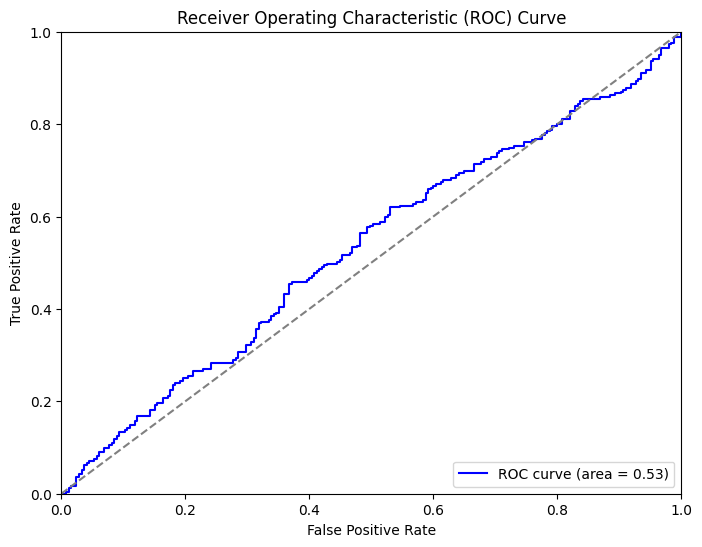

AUC Score: 0.53


In [25]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

def evaluate_roc_auc(model, holdout_loader):
    model.eval()
    all_probs = []
    all_labels = []
    with torch.no_grad():
        for images, labels in holdout_loader:
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)[:, 1]  # Assuming binary classification
            all_probs.extend(probs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    fpr, tpr, thresholds = roc_curve(all_labels, all_probs)
    auc_score = roc_auc_score(all_labels, all_probs)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {auc_score:.2f})')
    plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

    return auc_score

# Example usage
auc_score = evaluate_roc_auc(final_model, holdout_loader)
print(f'AUC Score: {auc_score:.2f}')
